In [1]:
import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
noise = pd.read_csv('data_noisy_gain0', header=None, skip_blank_lines=False)
noise[0] = noise[0].str.replace("(", "")
noise[1] = noise[1].str.replace(")", "")

noise = noise.astype(float)
noise[2] = np.sqrt(noise[0]**2 + noise[1]**2) #power level of the 
noise[2] = 10*np.log10(noise[2]) #RSS

noise[3] = noise.index / len(noise) * 10

noise = noise.replace([np.inf, -np.inf], np.nan)
noise = noise.dropna(axis = 0, inplace=False)

# noise = noise[noise[2] <= 0]
noise_floor = sum(noise[2]) / len(noise[2])
print(noise_floor)
print(noise)

/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


-277.00472805545354
                     0              1            2         3
0         9.765920e-04  -4.882960e-04   -29.618318  0.000000
8        -9.765920e-04   0.000000e+00   -30.102868  0.000042
12        0.000000e+00  -9.765920e-04   -30.102868  0.000063
40       2.590280e-144  6.879150e-154 -1435.866533  0.000210
43        3.845790e-86   1.246360e-47  -469.043565  0.000226
...                ...            ...          ...       ...
1900255   2.886830e+74  6.940230e-310   744.604212  9.999574
1900271  2.599040e-144   0.000000e+00 -1435.851870  9.999658
1900291  1.817770e-306   3.139470e-63  -625.031437  9.999763
1900325   2.886830e+74  6.940200e-310   744.604212  9.999942
1900331  9.519900e-307  6.013470e-154 -1532.208749  9.999974

[83545 rows x 4 columns]


In [3]:
# drone = pd.read_csv('data_drone_gain0', header=None, skip_blank_lines=False) #datasets/drone1/180_degrees
drone = pd.read_csv('datasets/drone1/180_degrees', header=None, skip_blank_lines=False) #datasets/drone1/180_degrees
drone[0] = drone[0].str.replace("(", "")
drone[1] = drone[1].str.replace(")", "")

drone = drone.astype(float)
drone[2] = (drone[0]**2 + drone[1]**2) #power level of the 
drone[2] = 10*np.log10(drone[2]) #RSS

drone[3] = drone.index / len(drone) * 10

print(len(drone))
drone = drone.replace([np.inf, -np.inf], np.nan)
drone = drone.dropna(axis = 0, inplace=False)
print(len(drone))



drone = drone[drone[2] <= 0]
drone = drone[drone[2] >= noise_floor]
print(len(drone))

drone = drone.rename({0: 'i', 1: 'q', 2: 'rss', 3: 'time'}, axis=1)

1660720
86659
1067


/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


662


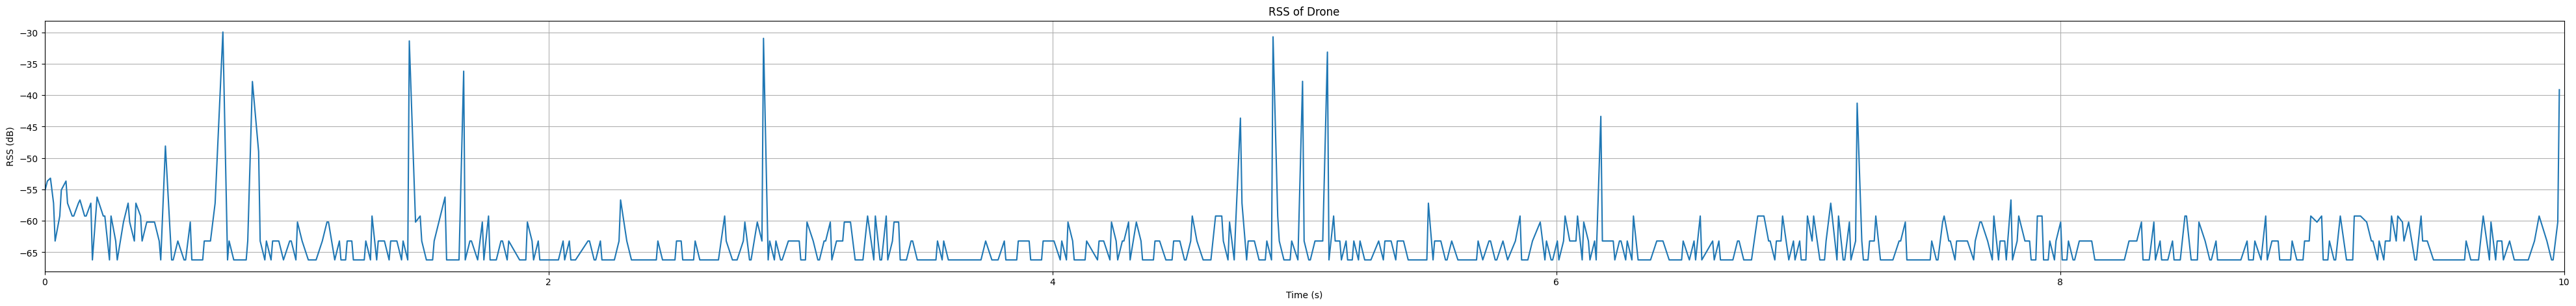

In [4]:
drone = drone[drone['rss'] >= -90]
print(len(drone))
plt.figure(figsize=(50, 5))
# plt.plot(drone[3][:200], drone[2][:200])
plt.plot(drone['time'], drone['rss'])
plt.title('RSS of Drone')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()

In [5]:
average = drone['rss'].mean() + 10

drone['rolling_rss'] = drone['rss'].rolling(window=8).mean()
drone = drone[drone['rss'] >= -90]

parts = drone.copy()
parts.loc[parts.rolling_rss <= average, 'rolling_rss'] = 0
parts['rolling_rss'] = parts['rolling_rss'].abs()

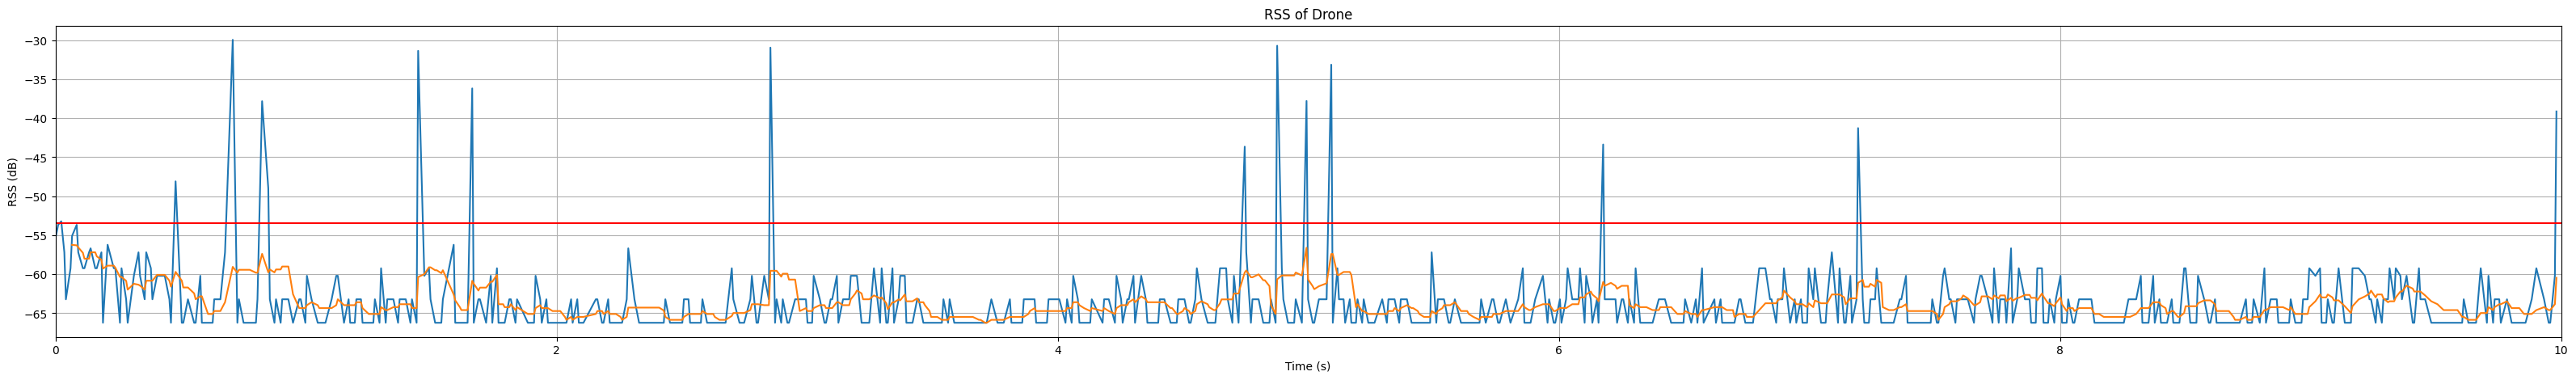

In [6]:
plt.figure(figsize=(40, 5))
plt.plot(drone['time'], drone['rss'])
# plt.plot(drone[3], drone[2])
plt.plot(drone['time'], drone['rolling_rss'])
plt.axhline(y = average, color = 'r', linestyle = '-')
plt.title('RSS of Drone')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()

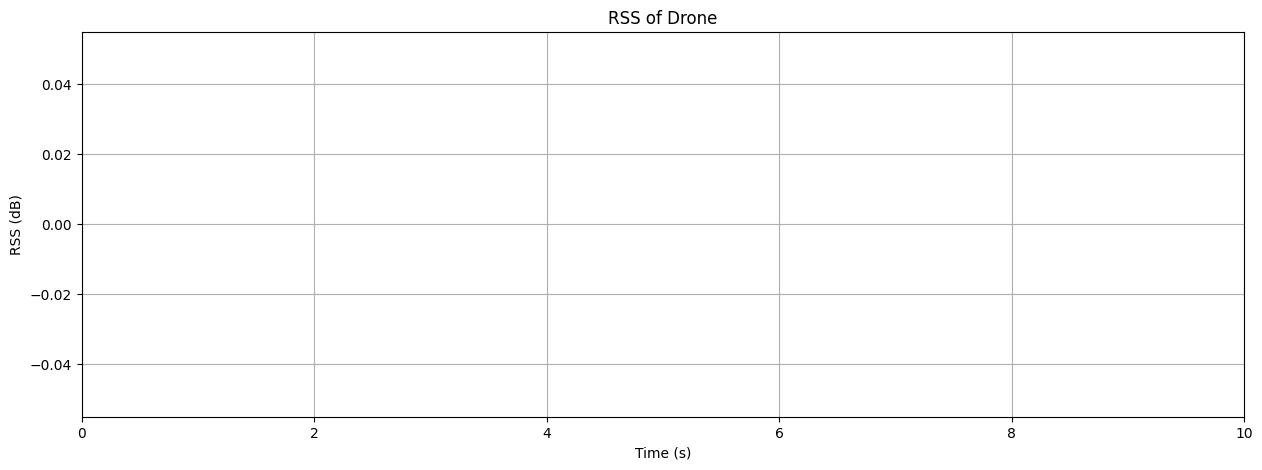

In [7]:
plt.figure(figsize=(15, 5))
# plt.plot(drone['time'], drone['rss'])
plt.bar(parts['time'], parts['rolling_rss'], width=.04)
plt.title('RSS of Drone')
plt.xlabel('Time (s)')
plt.xlim([0, 10])
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()

# IQ samples

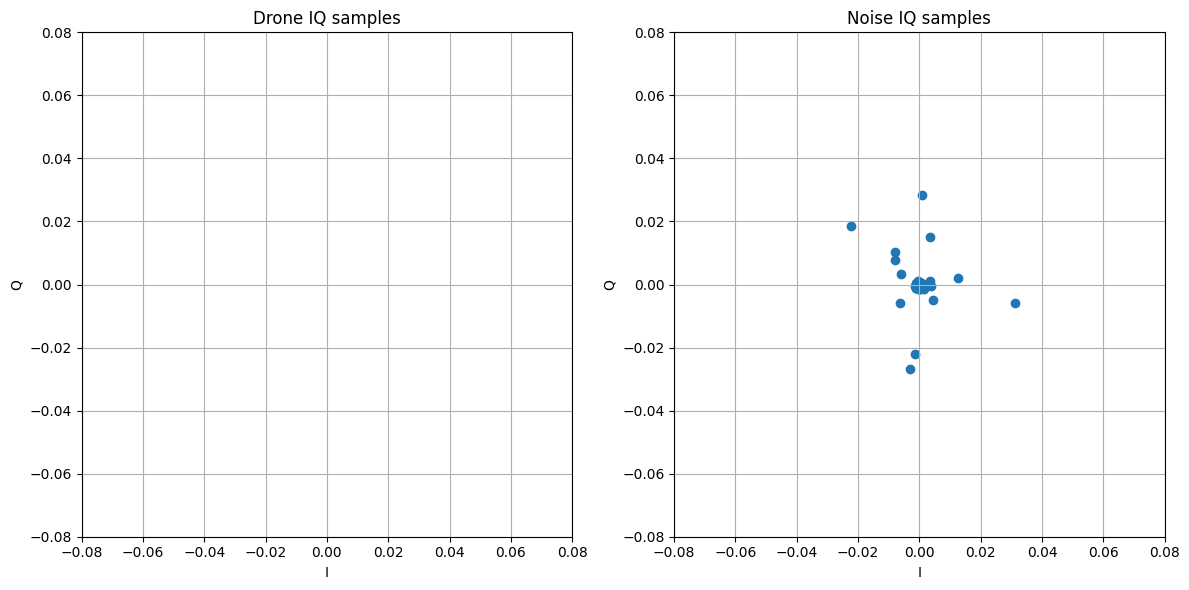

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))



ax1.scatter(parts[parts['rolling_rss'] > 0]['i'], parts[parts['rolling_rss'] > 0]['q'])
ax1.set_xlabel('I')
ax1.set_xlim([-0.08, 0.08])
ax1.set_ylabel('Q')
ax1.set_ylim([-0.08, 0.08])
ax1.grid()
ax1.set_title('Drone IQ samples')

ax2.scatter(parts[parts['rolling_rss'] <= 0]['i'], parts[parts['rolling_rss'] <= 0]['q'])
ax2.set_xlabel('I')
ax2.set_xlim([-0.08, 0.08])
ax2.set_ylabel('Q')
ax2.set_ylim([-0.08, 0.08])
ax2.grid()
ax2.set_title('Noise IQ samples')

plt.tight_layout()
plt.show()

<PolarAxes: >

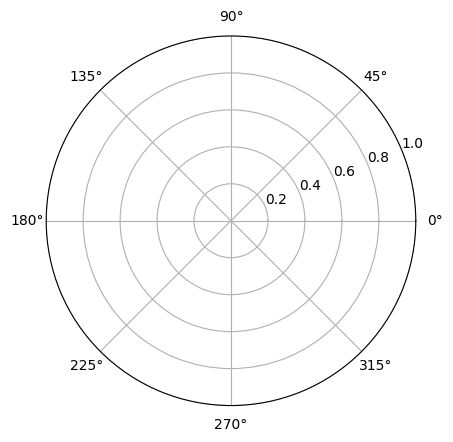

In [9]:
plt.subplot(polar=True)

# Radiation Patterns

In [10]:
radiation_patterns = []

directory = 'datasets/drone1/'  # Replace with the actual directory path
drone_radiation_pattern = None
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = pd.read_csv(directory + filename, header=None, skip_blank_lines=False)
        data[0] = data[0].str.replace("(", "")
        data[1] = data[1].str.replace(")", "")

        data = data.astype(float)
        data[2] = (data[0]**2 + data[1]**2) #power level of the 
        data[2] = 10*np.log10(data[2]) #RSS

        data[3] = degrees

        data = data.replace([np.inf, -np.inf], np.nan)
        data = data.dropna(axis = 0, inplace=False)

        data = data.rename({0: 'i', 1: 'q', 2: 'rss', 3: 'angle'}, axis=1)
        
        if drone_radiation_pattern is None:
            drone_radiation_pattern = data
        else:
            drone_radiation_pattern = pd.concat([drone_radiation_pattern, data])

radiation_patterns.append(drone_radiation_pattern)

directory = 'datasets/drone2/'  # Replace with the actual directory path
drone_radiation_pattern = None
for filename in tqdm(os.listdir(directory)):
    if os.path.isfile(os.path.join(directory, filename)):
        file_parts = filename.split('_')
        if len(file_parts) > 1:
            degrees = int(file_parts[0])

        data = pd.read_csv(directory + filename, header=None, skip_blank_lines=False)
        data[0] = data[0].str.replace("(", "")
        data[1] = data[1].str.replace(")", "")

        data = data.astype(float)
        data[2] = (data[0]**2 + data[1]**2) #power level of the 
        data[2] = 10*np.log10(data[2]) #RSS

        data[3] = degrees

        data = data.replace([np.inf, -np.inf], np.nan)
        data = data.dropna(axis = 0, inplace=False)

        data = data.rename({0: 'i', 1: 'q', 2: 'rss', 3: 'angle'}, axis=1)
        
        if drone_radiation_pattern is None:
            drone_radiation_pattern = data
        else:
            drone_radiation_pattern = pd.concat([drone_radiation_pattern, data])

radiation_patterns.append(drone_radiation_pattern)

  0%|          | 0/16 [00:00<?, ?it/s]/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
  6%|▋         | 1/16 [00:02<00:41,  2.76s/it]/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 12%|█▎        | 2/16 [00:05<00:37,  2.71s/it]/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 19%|█▉        | 3/16 [00:08<00:34,  2.65s/it]/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
 25%|██▌       | 4/16 [00:10<00:32,  2.70s/it]/home/jos/.local/lib/python3.11/site-packages/pandas/c

In [ ]:
# for drp in radiation_patterns:
#     all_angles = drone_radiation_pattern['angle'].unique()
#     all_angles.sort()

#     fig, axis = plt.subplots(nrows=16, ncols=1, figsize=(20, 6*16))

#     for i in range(len(all_angles)):
#         iq_samples = drone_radiation_pattern[drone_radiation_pattern['angle'] == all_angles[i]]

#         iq_samples = iq_samples[iq_samples['rss'] <= 0]
#         iq_samples = iq_samples[iq_samples['rss'] >= noise_floor]
        
#         # average = iq_samples['rss'].mean()

#         iq_samples['rolling_rss'] = iq_samples['rss'].rolling(window=8).mean()
#         # iq_samples = iq_samples[iq_samples['rss'] >= -90]

#         # iq_samples.loc[iq_samples.rolling_rss <= average, 'rolling_rss'] = 0
#         iq_samples['rolling_rss'] = iq_samples['rolling_rss'].abs()
#         ax = axis[i]
#         print(iq_samples)

#         ax.plot(iq_samples['rss'])
#         ax.plot(iq_samples['rolling_rss'])
#         ax.axhline(y = average, color = 'r', linestyle = '-')
#         ax.set_title('RSS of at angle ' + str(all_angles[i]))
#         ax.set_xlabel('Time (s)')
#         ax.set_xlim([0, 10])
#         ax.set_ylabel('RSS (dB)')

#     plt.tight_layout()
#     plt.show()


In [12]:
all_angles = radiation_patterns[0]['angle'].unique()
all_angles.sort()

rss_values_radiation_patterns = []

for drp in radiation_patterns:
    rss_values = {}
    for i in range(len(all_angles)):
        iq_samples = drp[drp['angle'] == all_angles[i]]

        iq_samples = iq_samples[iq_samples['rss'] <= 0]
        iq_samples = iq_samples[iq_samples['rss'] >= noise_floor]

        rss_values[all_angles[i]] = iq_samples[iq_samples['rss'] >= -50]['rss'].mean()
    rss_values_radiation_patterns.append(rss_values)

In [13]:
def create_radiation_pattern(ax, data_dict, scale=1, y_limit=None, title=None):
    #  Extracting the index and value from the dictionary
    indices = list(data_dict.keys())
    values = list(data_dict.values())

    # Scaling the values
    values = [value * scale for value in values]

    # Converting the indices to radians
    angles = np.radians(indices)

    # Adding the first angle at the end to close the plot
    angles = np.append(angles, angles[0])

    # Adding the first value at the end to close the plot
    values = np.append(values, values[0])

    # Creating the round plot
    ax.plot(angles, values, marker='o')

    ax.set_title(title)

    # Setting the labels for each angle
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(indices)

    # Limiting the y-values if specified
    if y_limit is not None:
        ax.set_ylim(y_limit)


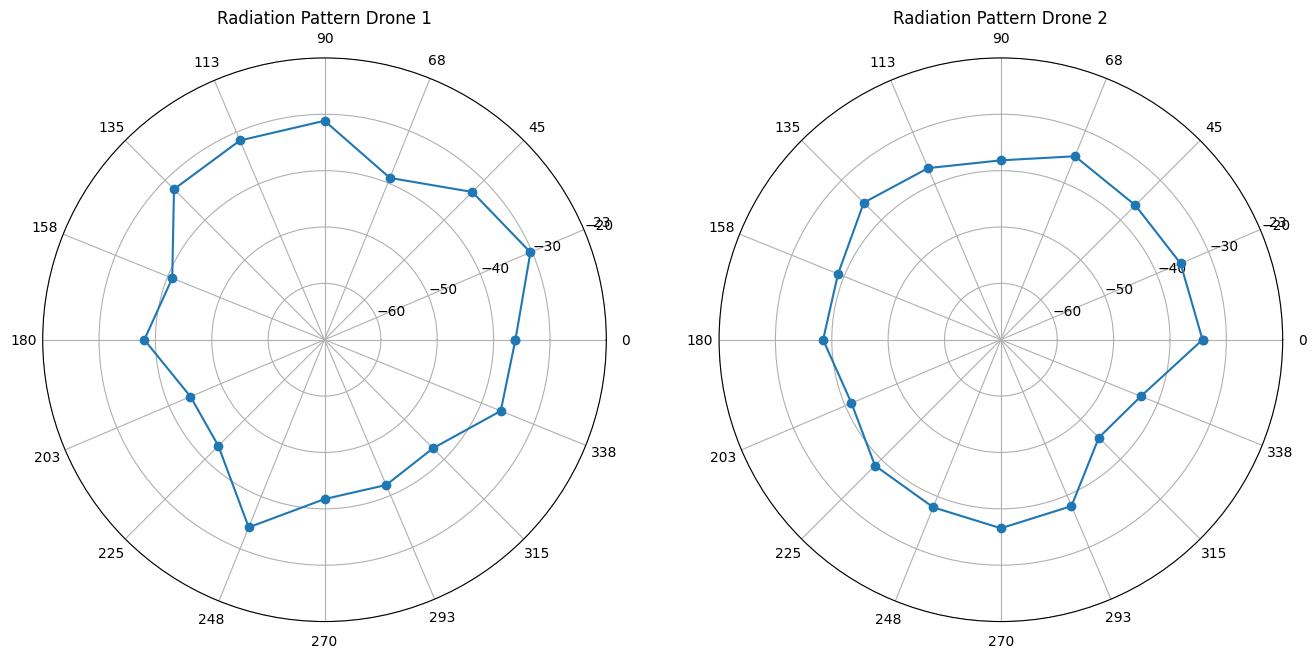

In [14]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), subplot_kw={'projection': 'polar'})

for i in range(len(rss_values_radiation_patterns)):
    create_radiation_pattern(axis[i], rss_values_radiation_patterns[i], y_limit=(-70, -20), title='Radiation Pattern Drone ' + str(i+1))
plt.show()

In [1]:
import pandas as pd
import os
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import struct

In [2]:
i_values = []
q_values = []

with open('test2', 'rb') as file:
    while True:
        # Read 4 bytes (32 bits) from the file
        i = file.read(4)
        if not i:
            break

        q = file.read(4)
        if not 1:
            break

        # Unpack the binary data into a single float
        i = struct.unpack('f', i)[0]
        q = struct.unpack('f', q)[0]

        i_values.append(i)
        q_values.append(q)

drone = pd.DataFrame({'i': i_values, 'q': q_values})

In [3]:
drone['time'] = drone.index / len(drone) * 3

drone['rss'] = 10*np.log10(drone['i']**2 + drone['q']**2) #RSS
drone = drone[drone['rss'] <= 0]
drone = drone[drone['rss'] >= -200]


drone = drone.replace([np.inf, -np.inf], np.nan)
drone = drone.dropna(axis = 0, inplace=False)


/home/jos/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


17637008


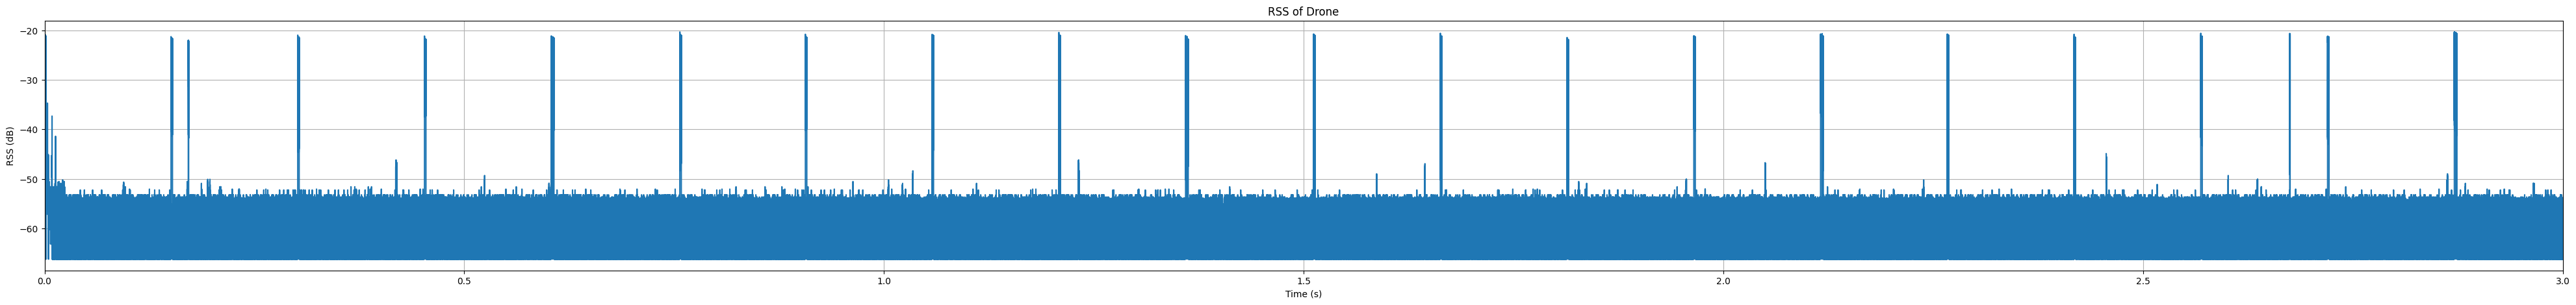

In [ ]:
drone = drone[drone['rss'] >= -90]
print(len(drone))
plt.figure(figsize=(50, 5))
# plt.plot(drone[3][:200], drone[2][:200])
plt.plot(drone['time'], drone['rss'])
plt.title('RSS of Drone')
plt.xlabel('Time (s)')
plt.xlim([0, 3])
plt.ylabel('RSS (dB)')
plt.grid(True)
plt.show()